In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# import csv
wiki_feat = pd.read_csv('../WebScraper/wikiarticles.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index
wiki_feat['date_article_creation'] = wiki_feat['date_article_creation'].str[7:] #strip time

# clean up column 'date_article_creation' and make 'days_since_creation'
wiki_feat['date_article_creation']= pd.to_datetime(wiki_feat['date_article_creation'], errors='coerce')
today = pd.to_datetime(dt.date.today())
wiki_feat['days_since_creation'] = (today - wiki_feat['date_article_creation']) / pd.Timedelta(1, 'D') # convert timedelta object to pure day by dividing by 1 d

In [3]:
lang_nums = [] # target
ref_counts = [] # feat2
body_text_lens = [] # feat3
main_article_num = [] # feat4
see_also_num = [] # feat5
further_info_num = [] # feat6

table_text_lens = [] # feat8
sports = [] # feat9
wiki_link_nums = [] # feat10
exec_counter = 0

for article in wiki_feat.index:
    filename = "../wikiarticles/" + article + ".html"
    html_handle = open(filename)
    html_text = html_handle.read()
    soup = BeautifulSoup(html_text, 'lxml')

    # filling list for target
    lang_section = soup.find("nav", {"id":"p-lang"})
    lang_num = len(lang_section.find_all('li'))
    lang_nums.append(lang_num)

    # filling list for feature 2, extract number of references from html
    try:
        ref_count = len(soup.find('ol', class_='references').find_all('li'))
    except AttributeError: #when there are no references
        ref_count = 0
    ref_counts.append(ref_count)
    
    # use for finding features 3-7
    body_text = soup.find("div", {"id":"mw-content-text"}).text

    # filling list for feature 3, extract length of body text
    len_body_text = len(body_text)
    body_text_lens.append(len_body_text)

    # find all occurances of "Main article:" or "Main articles:" (feat 4)
    main_article_count = 0
    for main_article in re.finditer('Main article:', body_text):
        main_article_count += 1
    for main_articles in re.finditer('Main articles:', body_text):
        main_article_count += 1
    main_article_num.append(main_article_count)

    # find all occurances of "See also:" (feat 5)
    see_also_count = 0
    for see_also in re.finditer('See also:', body_text):
        see_also_count += 1
    see_also_num.append(see_also_count)

    # find all occurnaces of "Further information:" (feat 6)
    further_info_count = 0
    for further_info in re.finditer('Further info:', body_text):
        further_info_count += 1
    further_info_num.append(further_info_count)

    # find is text includes "please help improve" (feat 7)

    # find all text within any tables, and find length (feat 8)
    table_list = soup.find_all("table")
    table_text_len = 0
    for element in table_list:
        table_text_len += len(element.text)
    table_text_lens.append(table_text_len)

    # is this article sports? (feat 9)
    category_text = soup.find("div", {"id":"mw-normal-catlinks"}).text
    sport_list = ['Baseball', 'baseball', 'Basketball', 'basketball', 'Football', 'football', 'Soccer', 'soccer', 'Hockey', 'hockey', 'Volleyball', 'volleyball', 'Tennis', 'tennis', 'Cricket', 'cricket', 'Golf', 'golf']
    sports_bool = 0
    for sport in sport_list:
        if re.findall(sport, category_text) != []:
            sports_bool = 1
    sports.append(sports_bool)

    # number of links to other wiki articles (feat 10)
    body_html = soup.find("div", {"id":"mw-content-text"})
    for div in body_html.find_all("div", {'class':'navbox'}): # delete all navboxes
        div.decompose()
    for table in body_html.find_all("table"): # delete all tables
        table.decompose()
    num_wiki_links = 0
    for link in soup.find_all('a', attrs={'href': re.compile("/wiki/")}):
        num_wiki_links += 1
    for link in soup.find_all('a', attrs={'href': re.compile("/w/index.php")}):
        num_wiki_links += 1
    wiki_link_nums.append(num_wiki_links)
    

    exec_counter += 1
    print(exec_counter)

wiki_feat['languages'] = lang_nums
wiki_feat['references'] = ref_counts
wiki_feat['text_length'] = body_text_lens
wiki_feat['main_article_num'] = main_article_num
wiki_feat['see_also_num'] = see_also_num
wiki_feat['further_info_num'] = further_info_num
wiki_feat['table_text_len'] = table_text_lens
wiki_feat['sports'] = sports
wiki_feat['wiki_link_num'] = wiki_link_nums

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [48]:
# # playground
# filename = "../wikiarticles/Ice.html"
# html_handle = open(filename)
# html_text = html_handle.read()
# soup = BeautifulSoup(html_text, 'lxml')

1


In [7]:
wiki_feat.dropna(inplace=True)
wiki_feat.drop(columns = ['further_info_num'], inplace=True, errors='ignore')
#  wiki_feat.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore')


In [17]:
wiki_feat.sort_values(by='languages',ascending=False).head(10)
wiki_feat.sort_values(by='text_length',ascending=False).head(10)
wiki_feat.sort_values(by='wiki_link_num',ascending=False).head(10)

,date_article_creation,days_since_creation,languages,references,text_length,main_article_num,see_also_num,table_text_len,sports,wiki_link_num
article_name,,,,,,,,,,
2000s in music,2004-01-08,6115.0,2,112,97156,1,3,3062,0,1633
Miami Hurricanes football,2020-08-17,49.0,1,460,155061,10,2,11033,1,1117
Immigration to the United States,2012-08-21,2967.0,19,10,220922,9,5,36819,0,1043
PAOK FC,2007-08-07,4808.0,49,333,125741,5,3,25329,1,938
1858,2011-11-06,3256.0,166,9,20258,0,0,1816,0,868
Eucalyptus,2012-05-08,3072.0,91,105,69373,3,0,1078,0,826
Noise in music,2008-04-06,4565.0,5,124,63331,4,2,62,0,794
Alasdair Óg of Islay,2009-01-16,4280.0,4,28,113921,0,0,345,0,708
List of mathematicians (G),2017-09-10,1121.0,0,0,22380,0,0,204,0,669


(array([1202.,  657.,  676.,  460.,  328.,  172.,   93.,   37.,   11.,
           3.]),
 array([0.        , 0.51179938, 1.02359876, 1.53539814, 2.04719752,
        2.55899691, 3.07079629, 3.58259567, 4.09439505, 4.60619443,
        5.11799381]),
 &lt;a list of 10 Patch objects&gt;)

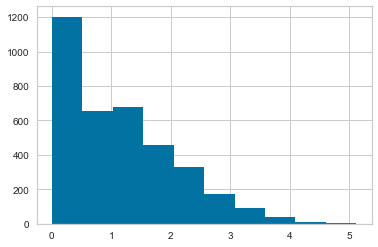

In [22]:
%matplotlib inline

# plt.scatter(wiki_feat['wiki_link_num'],wiki_feat['languages'], alpha=0.5)
# sns.pairplot(wiki_feat, height=1.2, aspect=1.25);
plt.hist(np.log(wiki_feat['languages']+1))

In [6]:
wiki_feat[wiki_feat['languages'] > 30].count()


date_article_creation    70
days_since_creation      70
languages                70
references               70
text_length              70
main_article_num         70
see_also_num             70
table_text_len           70
sports                   70
wiki_link_num            70
dtype: int64

In [7]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = wiki_feat.loc[:, ['days_since_creation','references','text_length', 'main_article_num', 'see_also_num','table_text_len','sports','wiki_link_num']]

# Target
y = wiki_feat['languages']

# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.22154241381735218

In [14]:
p = PolynomialFeatures()
X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)

[[1.0000e+00 4.2130e+03 3.0000e+00 ... 1.0000e+00 1.0200e+02 1.0404e+04]
 [1.0000e+00 2.5530e+03 6.0000e+00 ... 1.0000e+00 7.4000e+01 5.4760e+03]
 [1.0000e+00 6.0350e+03 3.0000e+00 ... 0.0000e+00 0.0000e+00 1.1025e+04]
 ...
 [1.0000e+00 4.3830e+03 2.4000e+01 ... 0.0000e+00 0.0000e+00 2.4964e+04]
 [1.0000e+00 2.1150e+03 1.0000e+00 ... 0.0000e+00 0.0000e+00 6.0840e+03]
 [1.0000e+00 7.5100e+02 2.0000e+00 ... 0.0000e+00 0.0000e+00 4.0960e+03]]


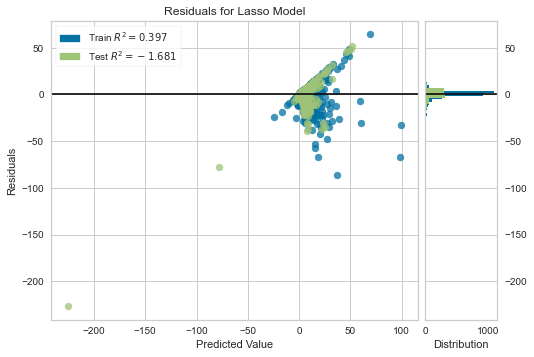

array([ 0.00000000e+00, -4.46081986e-04,  0.00000000e+00, -3.19700039e-04,
        0.00000000e+00,  0.00000000e+00,  3.30215744e-04, -0.00000000e+00,
        1.07238952e-01,  4.73838926e-08, -1.24448776e-05,  4.60078427e-09,
       -1.16332536e-04,  1.34827871e-04, -1.83053162e-08,  3.01180086e-04,
        2.37515669e-06, -2.06146062e-03,  4.87192706e-07,  1.02239905e-02,
       -0.00000000e+00,  3.92026474e-06,  0.00000000e+00,  6.82547600e-04,
        1.66204526e-08, -8.09826253e-05, -6.30747403e-05, -1.73742561e-08,
        1.54151655e-04, -3.86162340e-06, -3.28689444e-01,  0.00000000e+00,
       -6.82882126e-05, -0.00000000e+00,  2.32828627e-02,  0.00000000e+00,
        9.08615356e-06, -0.00000000e+00, -0.00000000e+00, -1.21274121e-09,
       -2.79875084e-04,  3.98543503e-06, -0.00000000e+00, -2.24639374e-02,
        8.04919147e-05])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from yellowbrick.regressor import ResidualsPlot

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Instantiate the linear model and visualizer
model = Lasso()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

visualizer.coef_

In [15]:
wiki_feat.to_csv(r'wiki_10feat.csv')